#### Dicom file Format ( Digital image and commnuication in medicine ) 
- Use Cases of Dicom Format : <br>
     dicom file stander from defferent types of Medical machine based on the company that desgin arch of machine for
     diagnosis patient and extract the many view of body in 3D 
     the dicom file store Metadata Patient's informations and fives moe stander way to make the commnuity Medicine commuicate even different machine scaner modality is Called **Digital image and commnuication in medicine** 
     <br>   
- Dioom file contain two important sections that store the data of patient 

  1. Header: is the part that keep the patient's information such :<br>
     in the HEADER contianting a series of informatoion wirtten as <br>
     <div class="alert alert-info"><strong> the HEADER </strong> Tag-->part body exminied --> CS:Chest</div> <br>
     
     * Device modality 
     * information patient 
     * serie of study
     * image's information 
 ***all most the time Header may could be private*** <br>
 ***3D slices are store in 2D multi files in dicom in case you also need to combined them at once in Proceesing*** 
  2. body : is the part describe the image shape and slicing view in different dimessions (2D , 3D , 4D ... ext )    
 


In [1]:
import pydicom as dc 
import matplotlib.pyplot as plt 
from pathlib import Path
import torch 
import glob2 as glob
import os
from vedo import dataurl, Volume, Text2D
from ipyvtk_simple.viewer import ViewInteractiveWidget
from vedo.applications import Slicer3DPlotter
from vedo.applications import RayCastPlotter
#plt = Plotter(backend='ipyvtk')


In [4]:
dicom_img = 'data3Dicom/'
list_path_case =[]

def path_cases(case, path_file):
    # path dicom_img/cases + 'number cases + /dir/dir/dir/IMG + numberIMG 
    cases_path = []
    file_img_path=[]
    list_path_img=[]
    for file_path in os.listdir(path_file):
        list_path_case.append(file_path)
        
    for paths_cases in range(0,len(list_path_case)):
        cases_path.append(os.path.join(dicom_img,list_path_case[paths_cases]))
  
    for full_path_list , subdirs , filename in os.walk(cases_path[case]): 
        file_img_path.append(full_path_list)
        for files_IMG in filename:
            list_path_img.append(os.path.join(full_path_list , files_IMG))
    
                                 
    return list_path_img[2:] , file_img_path[-1]
    
    
img , cases = path_cases(8,dicom_img)
image_size = img[1]
read_file = dc.read_file(image_size)
img_file = read_file.pixel_array
print(f"the number of images in this cases are {len(img)}\n and shape of images are {img_file.shape}")


the number of images in this cases are 337
 and shape of images are (512, 512)


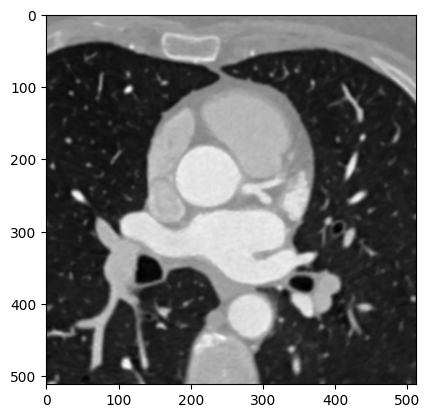

In [5]:
image , _ = path_cases(2,dicom_img)
read_file = dc.read_file(image[2])
img_file = read_file.pixel_array
plt.figure()
plt.imshow(img_file,cmap="gray")

In [6]:
### Projection all the CT image 
all_files_images_of_case ,_ = path_cases(5,dicom_img)
ct_reader_path = []
for path_img in all_files_images_of_case:
    read_img = dc.read_file(path_img)
    ct_reader_path.append(read_img)
    
for slice in ct_reader_path[:5]:
    print(slice.SliceLocation)

138.512
221.312
121.862
260.012
224.912


In [7]:
order_slices = sorted(ct_reader_path,key=lambda slice : slice.SliceLocation)
for slice in order_slices[:5]:
    print(slice.SliceLocation)

98.462
98.912
99.362
99.812
100.262


In [8]:
full_volume_casse = []

for slice in order_slices:
    full_volume_casse.append(slice.pixel_array)

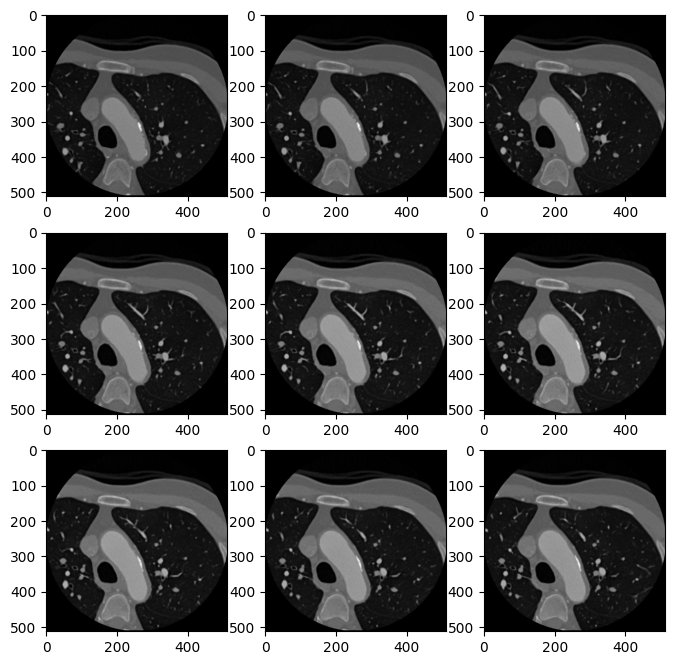

In [9]:
slice_counter = 0
fig , axes = plt.subplots(3,3,figsize=(8,8))
for i in range(3):
    for j in range(3):
        axes[i][j].imshow(full_volume_casse[slice_counter],cmap="gray")
        slice_counter+=1

In [10]:
### here we will use another package help us to reduce code callsed SimpleTik 
import SimpleITK as sitk 

In [11]:
img , cases = path_cases(3,dicom_img)
cases_path = Path(cases)

In [12]:
reader= sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(cases))
reader_Filenames= sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(cases),reader[0])
data_Images = sitk.ImageSeriesReader()
data_Images.SetFileNames(reader_Filenames)
data_to_numpy = data_Images.Execute()
Array_data = sitk.GetArrayFromImage(data_to_numpy)
Array_data.shape

print(f" Series IDs of Cases is {reader},\n Sample Dicom file taken is : , {reader_Filenames[0]} \n shape of images {Array_data.shape}")

 Series IDs of Cases is ('1.2.392.200036.9125.200031102200059001.65005691849.1.0.1',),
 Sample Dicom file taken is : , data3Dicom/case58/DATA/ANON2022/20220610/193729/EX1/SE1/IMG272 
 shape of images (272, 512, 512)


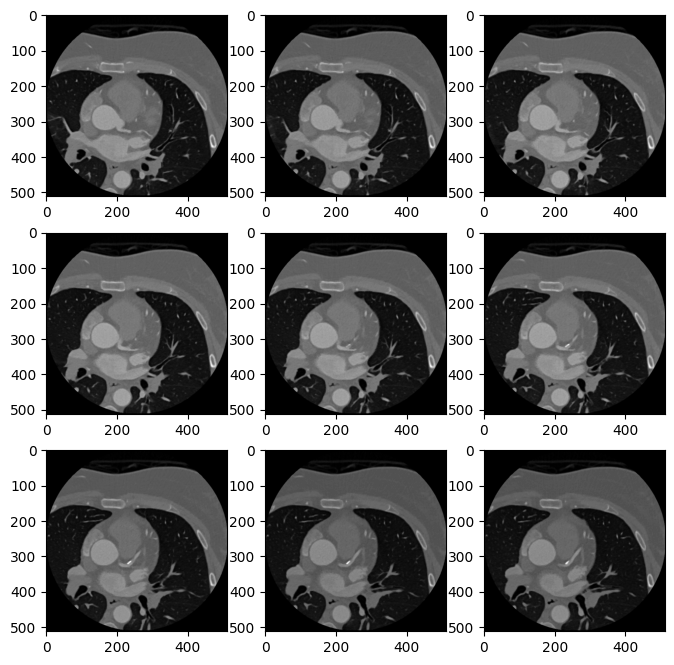

In [13]:
slice_counter = 0
fig , axes = plt.subplots(3,3,figsize=(8,8))
for i in range(3):
    for j in range(3):
        axes[i][j].imshow(Array_data[200:,: :][slice_counter],cmap="gray")
        slice_counter+=1

In [14]:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from skimage import measure

def plot_3d(image, threshold=-300): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values =measure.marching_cubes(p, threshold, allow_degenerate=True)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

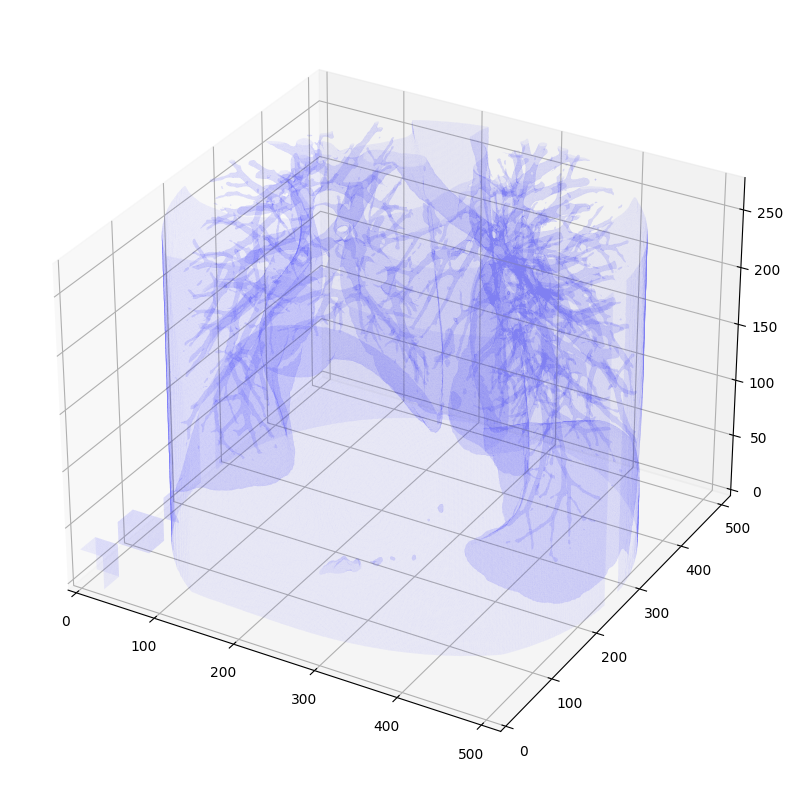

In [23]:
plot_3d(new_)

In [15]:
def _transform(dcm_dir,save_dir):
###   from dcm to nii
    ID_serie = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(cases))
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(str(dcm_dir))
    reader.SetFileNames(dicom_names)
    image2 = reader.Execute()
    
    
###   transform 3D image to array
    image_array = sitk.GetArrayFromImage(image2)  #  z,y,x
    print(f" Series IDs of Cases is {ID_serie} \n path of case {dicom_names[0]}, \n shape of images {image_array.shape}")

###   crop the dark voxel
#    new_array,range_list = get_bound(image_array)


###   transform array to 3D image
    image3 = sitk.GetImageFromArray(image_array)

###   save 3D image
    name = dcm_dir.split('/')[-1] + 'mesh3d.tif'
    save_path = os.path.join(save_dir,name)   #   get the save path
    sitk.WriteImage(image3,save_path) 

In [3]:
path_save = '03-Data-Formats/'
#_transform(cases,path_save)

In [2]:
path_save = '03-Data-Formats/'

filename = path_save + 'SE1mesh3d.tif'
# filename = dataurl+'embryo.tif'
# filename = dataurl+'vase.vti'

vol = Volume(filename)#.print()

plt = Slicer3DPlotter(
    vol,
    bg="white",
    bg2="lightblue",
    cmaps=("gist_ncar_r", "jet", "Spectral_r", "hot_r", "bone_r"),
    use_slider3d=True,
)

# plt = RayCastPlotter(vol, bg='black', bg2='blackboard', axes=7)  # Plotter instance

# plt.show(viewup="z").close()

# Can now add any other object to the Plotter scene:
# plt += Text2D('some message')
ViewInteractiveWidget(plt.show())

AttributeError: 'Slicer3DPlotter' object has no attribute 'SetOffScreenRendering'

In [12]:
### virtualize the 3D volume of Dicom file 
from vedo import *
device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

volume = Volume(Array_data)#returns a vtkVolume object
show(volume, bg='white')vol = Volume(data_matrix, c=['white','b','g','r'], mapper='gpu')
from vedo import Volume, show
vol = Volume(Array_data, c=['white','b','g','r'], mapper='gpu')
vol.add_scalarbar3d()
vol.print()

show(vol, __doc__, axes=1).close()

In [3]:
path_save = '03-Data-Formats/'

filename = path_save + 'SE1mesh3d.tif'
# filename = dataurl+'embryo.tif'
# filename = dataurl+'vase.vti'

vol = Volume(filename)#.print()

plt = Slicer3DPlotter(
    vol,
    bg="white",
    bg2="lightblue",
    cmaps=("gist_ncar_r", "jet", "Spectral_r", "hot_r", "bone_r"),
    use_slider3d=True,
)

# plt = RayCastPlotter(vol, bg='black', bg2='blackboard', axes=7)  # Plotter instance

# plt.show(viewup="z").close()

# Can now add any other object to the Plotter scene:
# plt += Text2D('some message')
plt.show()

In [ ]:
import vedo
vedo.Cone().show(axes=1).close()